Training subjects: 12, Testing subjects: 6
Final X_train shape: (29601, 36)
Final X_test shape: (15666, 36)

--- Random Forest (5-Fold CV) ---
Fold Accuracies: [0.94865732 0.95287162 0.95185811 0.95236486 0.95320946]
Mean Accuracy: 0.9517922750904934

Classification Report (CV RF):
               precision    recall  f1-score   support

           1       0.94      0.98      0.96     14196
           3       0.53      0.14      0.22       785
           4       0.78      0.31      0.44        59
           5       0.93      0.22      0.35        65
           6       0.92      0.92      0.92      5221
           7       1.00      1.00      1.00      6310
           8       1.00      1.00      1.00      2965

    accuracy                           0.95     29601
   macro avg       0.87      0.65      0.70     29601
weighted avg       0.94      0.95      0.94     29601



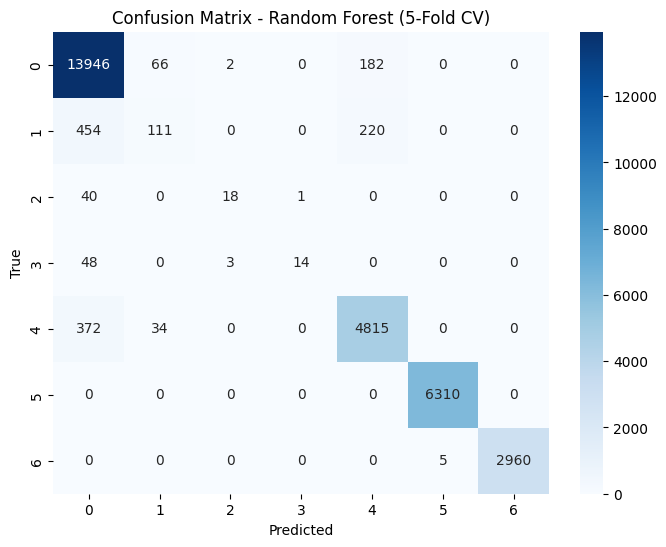

In [1]:
# # 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random
from scipy.fft import fft
from scipy.stats import mode
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


# 2. Shuffle and split subjects randomly
file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))
random.seed(42)  # for reproducibility
random.shuffle(file_paths)

# 80% train, 20% test
split_idx = int(0.7 * len(file_paths))
train_file_paths = file_paths[:split_idx]
test_file_paths = file_paths[split_idx:]

print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# 3. Full FFT + Statistical Feature Extraction Function
def extract_fft_stat_features(window_df, sampling_rate=50):
    features = {}
    sensor_cols = ['back_x',  'back_z', 'thigh_x',  'thigh_z']#'back_y','thigh_y',

    # Add magnitude columns
    window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
    window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)

    for col in sensor_cols + ['back_mag', 'thigh_mag']:
        arr = window_df[col].to_numpy()

        # FFT Features
        fft_vals = np.abs(fft(arr))
        n = len(arr)
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        dom_idx = np.argmax(fft_vals[1:]) + 1
        dom_freq = abs(freqs[dom_idx])
        spectral_energy = np.sum(fft_vals**2)

        features[f'{col}_dom_freq_hz'] = dom_freq
        features[f'{col}_spectral_energy'] = spectral_energy

        # Statistical Features (raw signal)
        features[f'{col}_mean'] = np.mean(arr)
        features[f'{col}_std'] = np.std(arr)
        features[f'{col}_median'] = np.median(arr)
        features[f'{col}_mode'] = mode(arr, keepdims=False)[0]

    return features

# 4. Process a subject file into sliding windows
def process_subject_fft(file_path, window_size_seconds=1, sampling_rate=50):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    features_list = []
    labels_list = []
    start_idx = 0
    total_samples = df.shape[0]

    while start_idx < total_samples:
        start_time = df.iloc[start_idx]['timestamp']
        end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]

        if len(window_df) < 10:
            start_idx += 1
            continue

        features = extract_fft_stat_features(window_df, sampling_rate)
        majority_label = Counter(window_df['label']).most_common(1)[0][0]

        features_list.append(features)
        labels_list.append(majority_label)
        start_idx = window_df.index[-1] + 1

    return pd.DataFrame(features_list), labels_list

# 5. Apply to all subjects
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for file in train_file_paths:
    features_df, labels = process_subject_fft(file)
    X_train_list.append(features_df)
    y_train_list.extend(labels)

for file in test_file_paths:
    features_df, labels = process_subject_fft(file)
    X_test_list.append(features_df)
    y_test_list.extend(labels)

# 6. Final datasets
X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
y_train = np.array(y_train_list)

X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
y_test = np.array(y_test_list)

print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)

# 1. Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 2. Define Stratified 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Define best models with tuned hyperparameters

# Random Forest
best_rf_model = RandomForestClassifier(
    n_estimators=700,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=60,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# #Gradient Boosting
# best_gb_model = GradientBoostingClassifier(
#     subsample=0.6,
#     n_estimators=200,
#     min_samples_split=10,
#     min_samples_leaf=1,
#     max_features='log2',
#     max_depth=12,
#     learning_rate=0.01,
#     random_state=42
# )

#4. Evaluate with cross_val_score

print("\n--- Random Forest (5-Fold CV) ---")
rf_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print("Fold Accuracies:", rf_scores)
print("Mean Accuracy:", np.mean(rf_scores))

# 5. Optional: Predictions for confusion matrix using cross_val_predict
y_pred_rf_cv = cross_val_predict(best_rf_model, X_train, y_train, cv=cv, n_jobs=-1)
print("\nClassification Report (CV RF):\n", classification_report(y_train, y_pred_rf_cv))

cm_rf_cv = confusion_matrix(y_train, y_pred_rf_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_cv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (5-Fold CV)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("confusion_matrix_rf_7.png")
plt.show()

# 6. Repeat for Gradient Boosting

# print("\n--- Gradient Boosting (5-Fold CV) ---")
# gb_scores = cross_val_score(best_gb_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
# print("Fold Accuracies:", gb_scores)
# print("Mean Accuracy:", np.mean(gb_scores))

# y_pred_gb_cv = cross_val_predict(best_gb_model, X_train, y_train, cv=cv, n_jobs=-1)
# print("\nClassification Report (CV GB):\n", classification_report(y_train, y_pred_gb_cv))

# cm_gb_cv = confusion_matrix(y_train, y_pred_gb_cv)
# plt.figure(figsize=(8,6))
# sns.heatmap(cm_gb_cv, annot=True, fmt='d', cmap='Greens')
# plt.title('Confusion Matrix - Gradient Boosting (5-Fold CV)')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # 7. Save the trained Random Forest model after CV evaluation
# print("\n[INFO] Saving the Random Forest model...")
# best_rf_model.fit(X_train, y_train)  # Fit on full training set
# joblib.dump(best_rf_model, "best_rf_model_fft_stat_final.pkl")
# print("✅ Model saved as 'best_rf_model_fft_stat_final.pkl'")



[INFO] Selected Top 10 Features using ANOVA F-test:
['back_x_spectral_energy', 'back_x_mean', 'back_x_median', 'back_z_spectral_energy', 'thigh_x_spectral_energy', 'thigh_x_mean', 'thigh_x_median', 'thigh_z_spectral_energy', 'thigh_z_mean', 'thigh_z_median']

--- Random Forest (5-Fold CV with ANOVA-selected features) ---
Fold Accuracies: [0.94798176 0.94611486 0.94695946 0.94780405 0.94797297]
Mean Accuracy: 0.9473666222378434

Classification Report (CV RF):
               precision    recall  f1-score   support

           1       0.94      0.98      0.96     14196
           3       0.53      0.07      0.12       785
           4       0.62      0.39      0.48        59
           5       0.67      0.25      0.36        65
           6       0.89      0.92      0.91      5221
           7       1.00      1.00      1.00      6310
           8       1.00      1.00      1.00      2965

    accuracy                           0.95     29601
   macro avg       0.81      0.66      0.69    

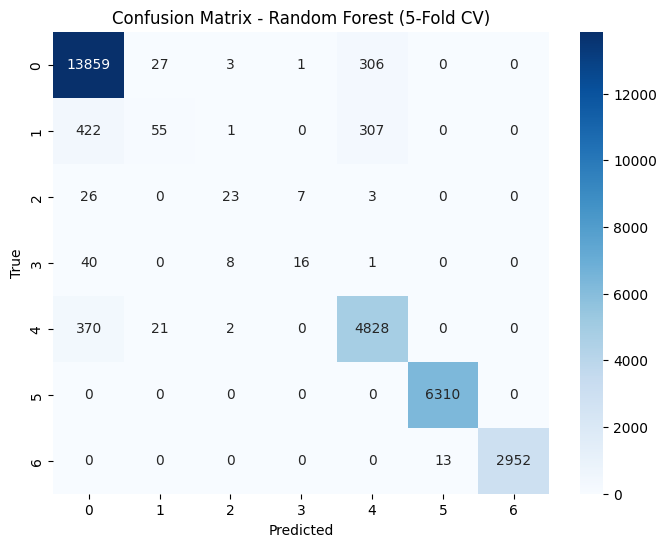

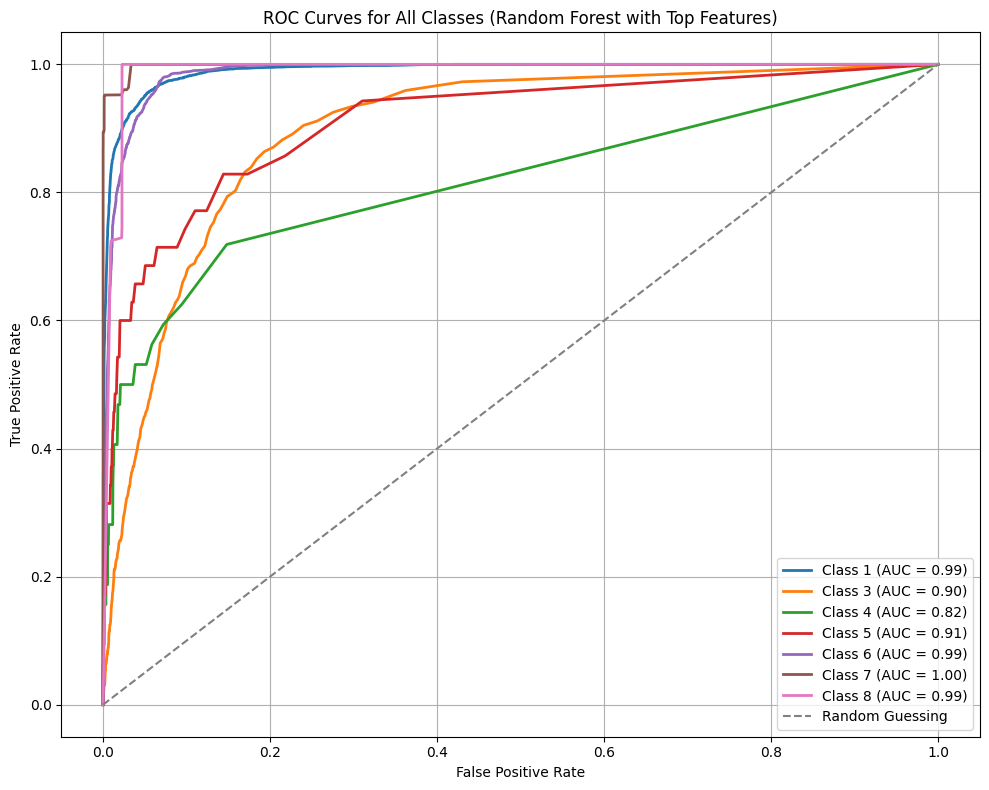

In [2]:
# 1. Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 2. Feature Selection using ANOVA (SelectKBest)
k = 10  # Choose number of top features you want to keep
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_feature_names = X_train.columns[selector.get_support()].tolist()
print(f"\n[INFO] Selected Top {k} Features using ANOVA F-test:")
print(selected_feature_names)

# 3. Define Stratified 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define Random Forest Model (tuned)
best_rf_model = RandomForestClassifier(
    n_estimators=700,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=60,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 5. Cross-Validation Evaluation
print("\n--- Random Forest (5-Fold CV with ANOVA-selected features) ---")
rf_scores = cross_val_score(best_rf_model, X_train_selected, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print("Fold Accuracies:", rf_scores)
print("Mean Accuracy:", np.mean(rf_scores))

# 6. Cross-Validation Predictions and Confusion Matrix
y_pred_rf_cv = cross_val_predict(best_rf_model, X_train_selected, y_train, cv=cv, n_jobs=-1)
print("\nClassification Report (CV RF):\n", classification_report(y_train, y_pred_rf_cv))

cm_rf_cv = confusion_matrix(y_train, y_pred_rf_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_cv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (5-Fold CV)')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig("confusion_matrix_rf_7_top10.png")
plt.show()

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output labels for multi-class ROC
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_train_bin.shape[1]

# Train One-vs-Rest RF on selected features
ovr_rf = OneVsRestClassifier(best_rf_model)
ovr_rf.fit(X_train_selected, y_train_bin)

# Predict probabilities on test set
y_score = ovr_rf.predict_proba(X_test_selected)

# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize class labels
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_train_bin.shape[1]

# Train One-vs-Rest model on selected features
ovr_model = OneVsRestClassifier(best_rf_model)
ovr_model.fit(X_train_selected, y_train_bin)

# Predict probabilities on test set
y_score = ovr_model.predict_proba(X_test_selected)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot random guess baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes (Random Forest with Top Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves_all_classes.png')
plt.show()


# # 7. Train on Full Training Set & Save Model
# print("\n[INFO] Saving the Random Forest model (with selected features)...")
# best_rf_model.fit(X_train_selected, y_train)
# joblib.dump((best_rf_model, selector), "best_rf_model_with_anova.pkl")
# print("✅ Model and feature selector saved as 'best_rf_model_with_anova.pkl'")



[INFO] Training Random Forest on full training data with selected features...


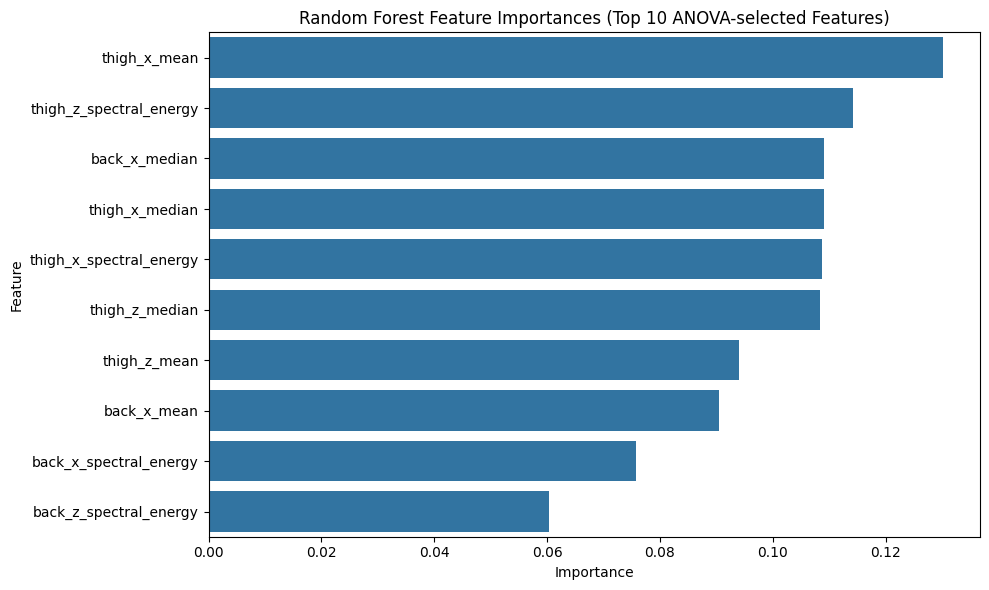

In [3]:
# 7. Train on Full Training Set (with selected features)
print("\n[INFO] Training Random Forest on full training data with selected features...")
best_rf_model.fit(X_train_selected, y_train)

# 8. Plot Feature Importances
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importances (Top 10 ANOVA-selected Features)')
plt.tight_layout()
plt.savefig("feature_importances_rf_top10.png")
plt.show()

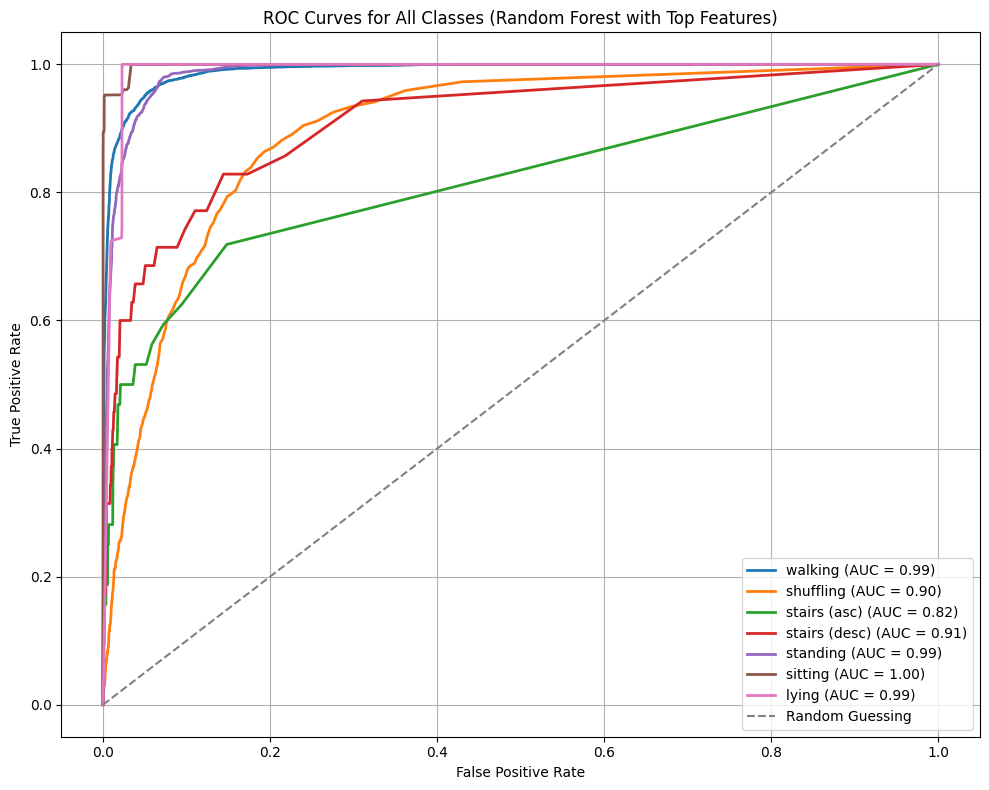

In [4]:
# Dictionary for label names
labels_dic = {
    1: 'walking',
    3: 'shuffling',
    4: 'stairs (asc)',
    5: 'stairs (desc)',
    6: 'standing',
    7: 'sitting',
    8: 'lying'
}

# Binarize class labels
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_train_bin.shape[1]

# Train One-vs-Rest model on selected features
ovr_model = OneVsRestClassifier(best_rf_model)
ovr_model.fit(X_train_selected, y_train_bin)

# Predict probabilities on test set
y_score = ovr_model.predict_proba(X_test_selected)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    label = labels_dic.get(classes[i], f"Class {classes[i]}")
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes (Random Forest with Top Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves_7_classes.png')
plt.show()


In [5]:
import pandas as pd  # Make sure pandas is imported

# Get scores and p-values
f_scores = selector.scores_
p_values = selector.pvalues_

# Create DataFrame for all features
anova_results = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': f_scores,
    'p-Value': p_values
}).sort_values(by='F-Score', ascending=False)

# Display the top k features
print("\n[INFO] ANOVA F-Test Results (All Features):")
print(anova_results.head(k))



[INFO] ANOVA F-Test Results (All Features):
                    Feature        F-Score  p-Value
16           thigh_x_median  227418.323904      0.0
14             thigh_x_mean  212390.966931      0.0
13  thigh_x_spectral_energy   51250.484994      0.0
22           thigh_z_median   43142.494348      0.0
20             thigh_z_mean   40188.421069      0.0
19  thigh_z_spectral_energy   36754.490201      0.0
2               back_x_mean   35923.043478      0.0
4             back_x_median   33081.159699      0.0
1    back_x_spectral_energy   23661.105726      0.0
7    back_z_spectral_energy   12207.256833      0.0
